In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
        # normalize
        
    ])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

# easy way

In [11]:
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(0.2861), tensor(0.3530))

# hard way

In [7]:
loader = DataLoader(train_set, batch_size=1000, num_workers=1)
num_of_pixels = len(train_set)*28*28

total_sum = 0
for batch in loader: total_sum += batch[0].sum()
mean = total_sum / num_of_pixels

sum_of_squared_error = 0
for batch in loader: sum_of_squared_error += (batch[0]-mean).pow(2).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

mean, std

(tensor(0.2860), tensor(0.3530))

# Plotting the Values

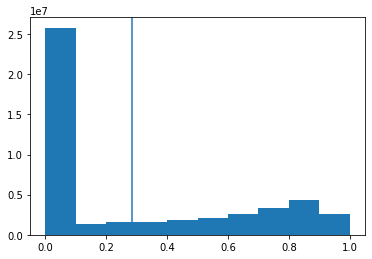

In [8]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())
# 0-> black value; 1 -> whith value

# Using the mean and std value

In [19]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
        # normalize
        , transforms.Normalize((0.2860,), (0.3530,))
    ])
)

In [20]:
loader = DataLoader(train_set_normal, batch_size=len(train_set_normal), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7428577390>>
Traceback (most recent call last):
  File "/home/scrutiny/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/scrutiny/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7491586470>>
Traceback (most recent call last):
  File "/home/scrutiny/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdo

(tensor(0.0001), tensor(1.0001))

(tensor(0.0001), tensor(1.0001))

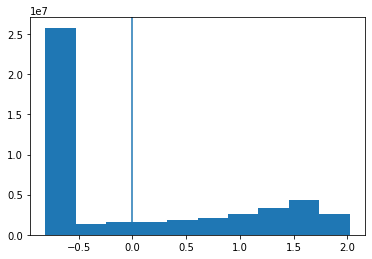

In [22]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())
data[0].mean(), data[0].std()

In [23]:
import time
import pandas as pd
from IPython.display import clear_output
import json
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
        
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images.to(getattr(run, 'device','cpu')))
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss/len(self.loader.dataset)
        accuracy = self.epoch_num_correct/len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item()*self.loader.batch_size
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns').to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json','w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [24]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):
        t = t 
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = t.reshape(-1, 12*4*4)  # t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        
        t = F.relu(self.fc2(t))
        
        t = self.out(t)
        return t
        

In [33]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product
from torch.utils.tensorboard import SummaryWriter
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs
    
    
    
trainsets = {
    'not_noraml': train_set,
    'normal': train_set_normal
}
# 使用RunManager和RunBuilder类可以使得程序更易扩展
params = OrderedDict(
    lr = [.01],
    batch_size =[1000],
    shuffle = [True],
    device = ['cuda'],
    num_workers = [1],
    trainsets = ['not_noraml', 'normal']
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device)
    network = Network().to(device)
    loader = torch.utils.data.DataLoader(trainsets[run.trainsets], batch_size=run.batch_size, shuffle=run.shuffle, num_workers=run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(1):
        m.begin_epoch()
        for batch in loader:
#             images, labels = batch
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('resuls')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle,device,num_workers,trainsets
0,1,1,1.053575,0.604983,3.664973,4.189378,0.01,1000,True,cuda,1,not_noraml
1,2,1,0.803175,0.699217,5.850704,6.439692,0.01,1000,True,cuda,1,normal


In [34]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle,device,num_workers,trainsets
1,2,1,0.803175,0.699217,5.850704,6.439692,0.01,1000,True,cuda,1,normal
0,1,1,1.053575,0.604983,3.664973,4.189378,0.01,1000,True,cuda,1,not_noraml
